In [2]:
!pip -q install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

Загружаем датасет для переменной CC50

In [4]:
df = pd.read_csv('dataset_for_CC50.csv')

Подготовим данные для обучения моделей.

In [5]:
target_col = 'CC50, mM'
X = df.drop(columns=[target_col]).select_dtypes(include=[np.number])
y = df[target_col].values

Разделяем датасеты

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Модели LinearRegression, DecisionTree, RandomForest и CatBoost.

In [7]:
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=False)
}

Оценка по MAE, RMSE, R2

In [8]:
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_true = np.asarray(y_test).ravel()
    y_pred = np.asarray(y_pred).ravel()

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

In [9]:
results_df = pd.DataFrame(results).sort_values('R2', ascending=False).reset_index(drop=True)
print(results_df.to_string(index=False))

           Model        MAE       RMSE       R2
    RandomForest 248.032087 352.214096 0.403978
        CatBoost 239.954705 360.022625 0.377258
LinearRegression 289.329078 374.682557 0.325510
    DecisionTree 270.462120 433.498342 0.097134


Подбор гиперпараметров и сохранение лучших моделей

In [10]:
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=False)
}

In [11]:
param_grids = {
    'DecisionTree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'RandomForest': {
        'n_estimators': [100, 300, 500],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    },
    'CatBoost': {
        'depth': [4, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'l2_leaf_reg': [1, 3, 5]
    }
}

In [12]:
tuned_models = {}

for name, model in models.items():
    print(f"Тюнинг: {name}")

    if name == 'LinearRegression':
        tuned_models[name] = model  # Без тюнинга
        continue

    param_grid = param_grids.get(name, {})

    search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=10,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train, y_train)
    tuned_models[name] = search.best_estimator_

Тюнинг: LinearRegression
Тюнинг: DecisionTree
Тюнинг: RandomForest
Тюнинг: CatBoost


Сравним

In [13]:
results = []
for name, model in tuned_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_true = np.asarray(y_test).ravel()
    y_pred = np.asarray(y_pred).ravel()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

In [14]:
results_df = pd.DataFrame(results).sort_values('R2', ascending=False).reset_index(drop=True)
print(results_df.to_string(index=False))

           Model        MAE       RMSE       R2
        CatBoost 246.875966 336.660701 0.455456
    RandomForest 252.248304 345.231117 0.427378
LinearRegression 289.329078 374.682557 0.325510
    DecisionTree 301.994813 403.166131 0.219062


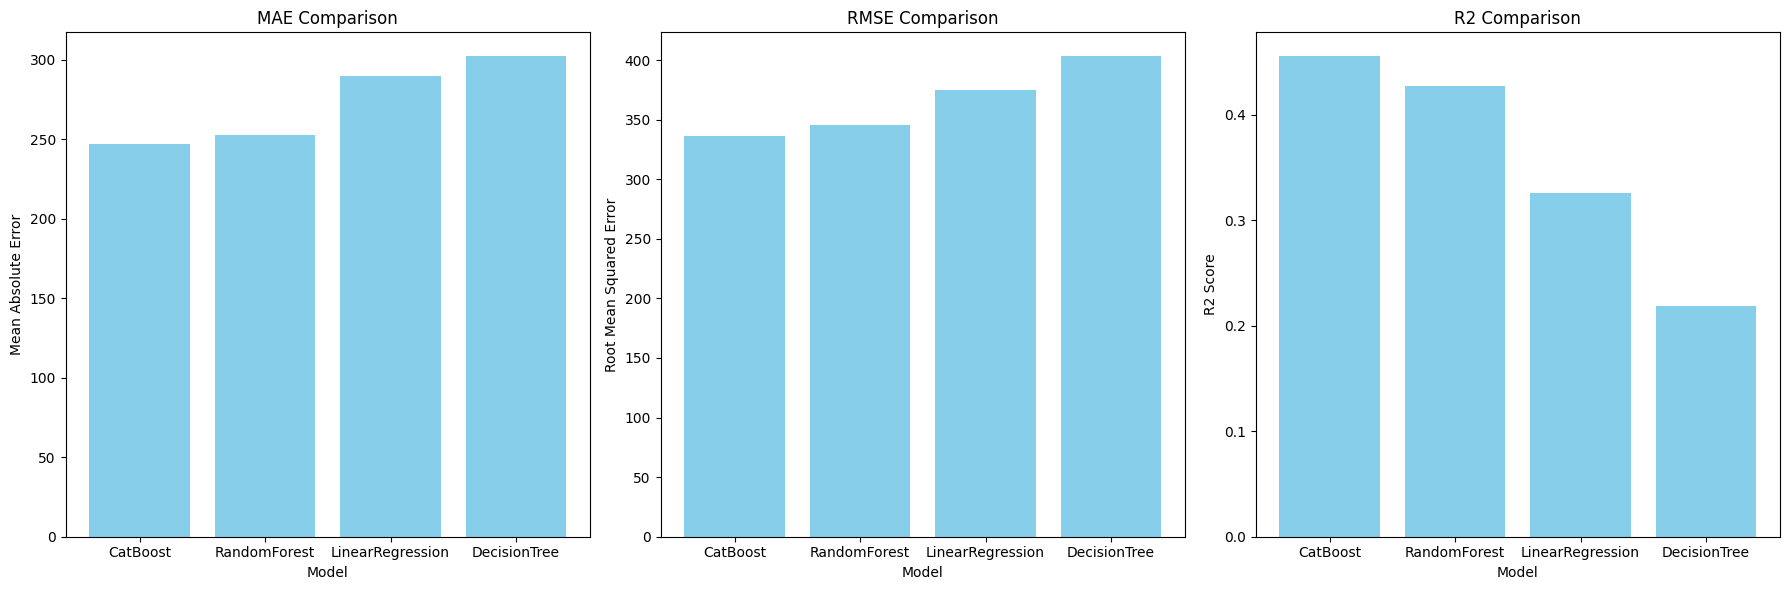

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Для MAE
axes[0].bar(results_df['Model'], results_df['MAE'], color='skyblue')
axes[0].set_title('MAE Comparison')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Mean Absolute Error')

# Для для RMSE
axes[1].bar(results_df['Model'], results_df['RMSE'], color='skyblue')
axes[1].set_title('RMSE Comparison')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Root Mean Squared Error')

# Для для R2
axes[2].bar(results_df['Model'], results_df['R2'], color='skyblue')
axes[2].set_title('R2 Comparison')
axes[2].set_xlabel('Model')
axes[2].set_ylabel('R2 Score')

# Показать графики
plt.tight_layout()
plt.show()

Касаемо переменной CC50  различия между разными моделями не столько драматичны, но видно, что лучше всего себя показали модель категориального бустинга и Случайного Леса.